In [1]:
from niche_fit import *
from niche_calib import *
from read_flasher_logs import *

from utils import *
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin','rutherford']
counters = ['bardeen','bell','curie','feynman','newton','noether','rossi','rubin']
calib_dict = {}
amp_dict = {}
for counter in counters:
    nraws = read_calib_files(counter)
    calibs = np.array([CalibPulse(r) for r in nraws],dtype='O')
    pulse_levels = np.array([c.pulse_mean for c in calibs])
    calibs = calibs[pulse_levels>40.]
    calib_dict[counter] = calibs
    trigtimes = np.array([c.trigtime() for c in calibs])
    amp_dict[counter] = np.array(run_multiprocessing(ampl_at_time,trigtimes))

|████████████████████████████████████████| 4867/4867 [100%] in 1.4s (3385.54/s) 
|████████████████████████████████████████| 5149/5149 [100%] in 1.3s (3857.24/s) 
|████████████████████████████████████████| 5033/5033 [100%] in 1.3s (4008.99/s) 
|████████████████████████████████████████| 5248/5248 [100%] in 3.5s (1516.59/s) 
|████████████████████████████████████████| 5237/5237 [100%] in 3.8s (1382.56/s) 
|████████████████████████████████████████| 5299/5299 [100%] in 3.2s (1679.12/s) 
|████████████████████████████████████████| 5551/5551 [100%] in 3.8s (1454.03/s) 
|████████████████████████████████████████| 5268/5268 [100%] in 3.7s (1442.88/s) 


/tmp/ipykernel_7472/3870296840.py:15: RuntimeWarning: Mean of empty slice.
  meanpulse.append(pms.mean())
/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/isaac/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


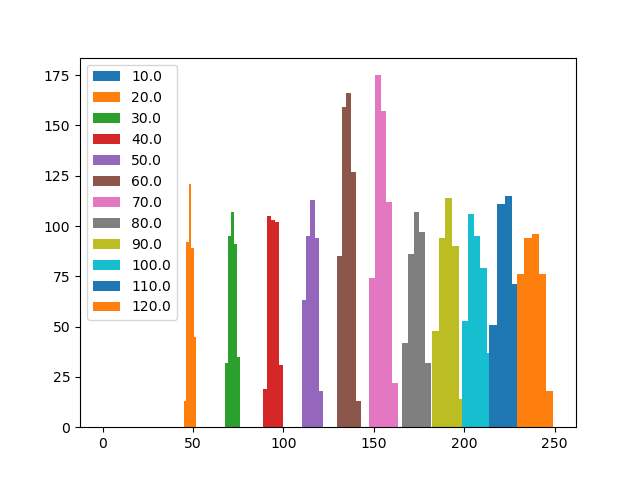

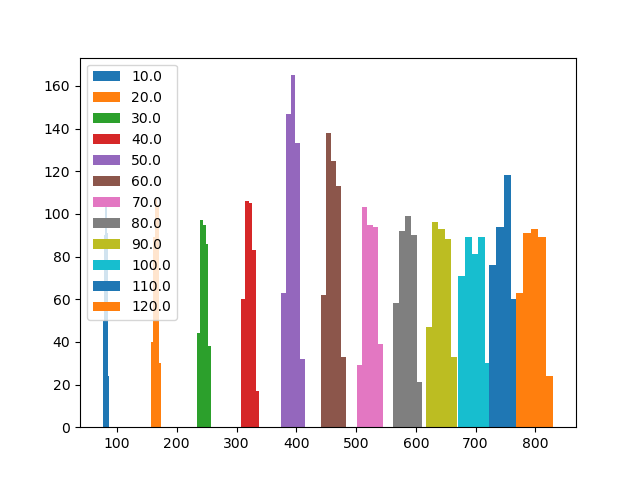

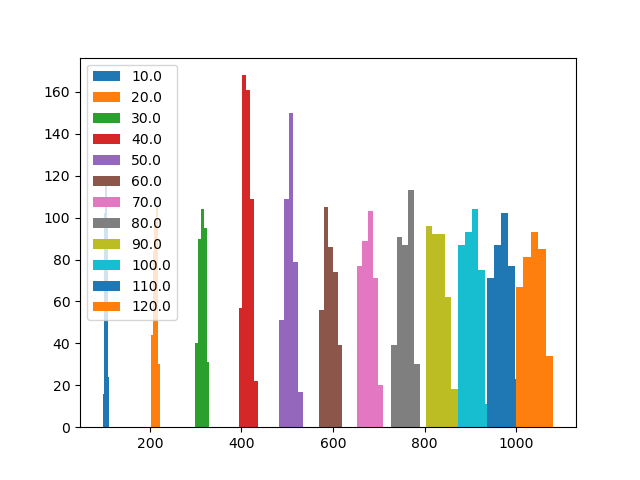

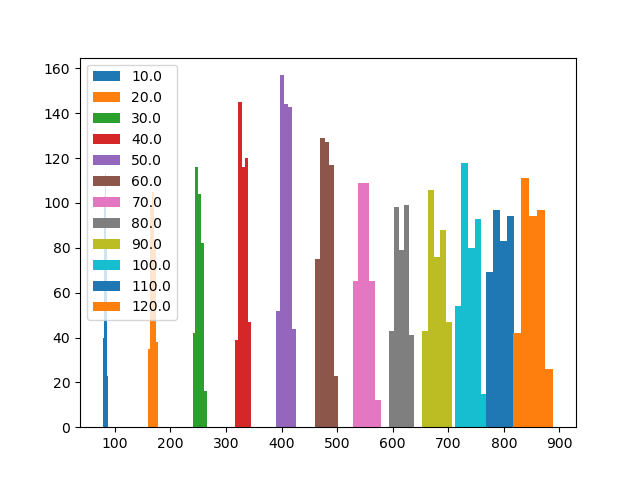

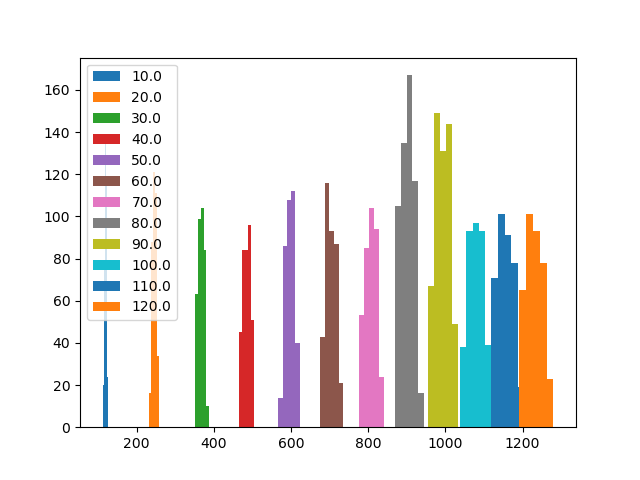

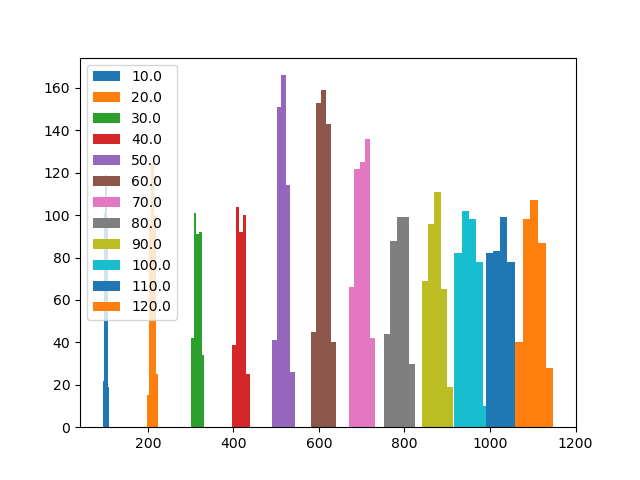

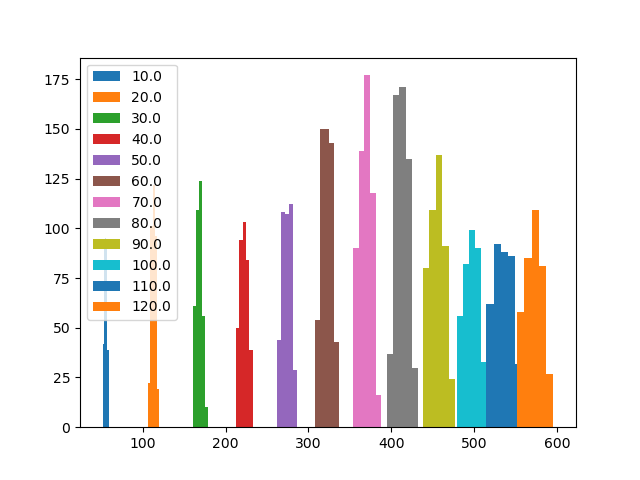

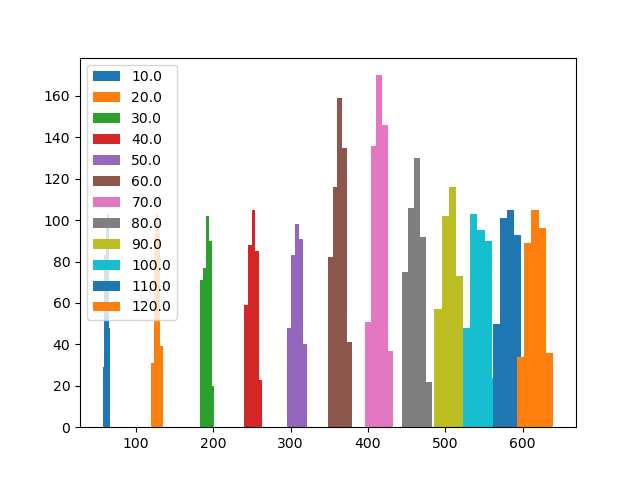

In [3]:
ampset = np.arange(1,13) * 10.
ns_dict = {}
var_dict = {}
mean2_dict = {}
meanpa_dict = {}
meanpulse_dict = {}
meanpulse_err_dict = {}
for counter in counters:
    meanpulse = []
    err = []
    plt.figure()
    for amp in ampset:
        pms = np.array([c.pulse.mean() for c in calib_dict[counter][amp_dict[counter]==amp]])
        plt.hist(pms, bins=5, label=amp)
        meanpulse.append(pms.mean())
        err.append(np.std(pms))
    plt.legend()
    meanpulse_dict[counter] = np.array(meanpulse)
    meanpulse_err_dict[counter] = np.array(err)

In [4]:
r = 62. #approximate cm
A = 77. #cm^2
niche_omega = A/r**2
pulse_time = 76*5. #in nanoseconds
qe = .35
# plt.figure()
# for counter in counters:
#     photons = ns_dict[counter] / qe
#     photons_per_omega_per_ns = photons / niche_omega / pulse_time
#     plt.scatter(ampset,photons_per_omega_per_ns, label = counter)
    

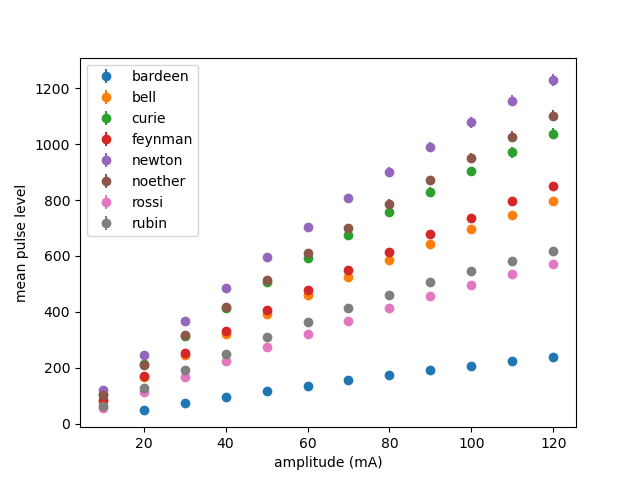

In [5]:
plt.figure()
for counter in counters:
    plt.errorbar(ampset, meanpulse_dict[counter],label = counter,yerr=meanpulse_err_dict[counter],linestyle='',marker='o')
plt.xlabel('amplitude (mA)')
plt.ylabel('mean pulse level')
plt.legend()

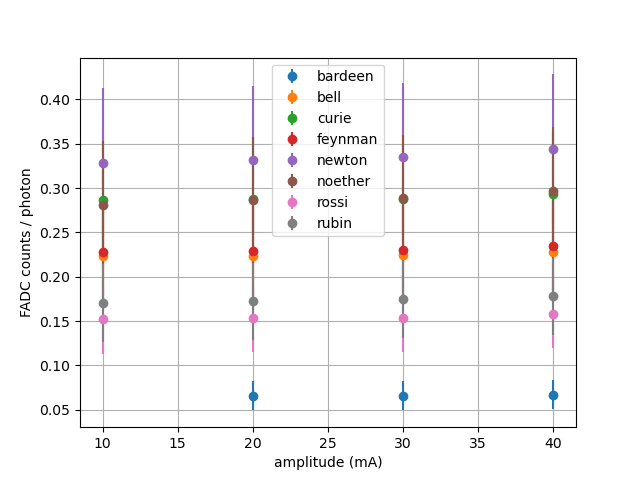

In [6]:
photons_per_omega_per_ns=np.array([3625.777169418993,
7371.932223605822,
10938.2824111218,
14059.85972612137])
# photons_err = np.array([14.151988913133007,
#  14.151990797454577,
#  14.151993844879817,
#  14.151989332065304])
photons_err = np.array([92.29028594330143, 184.51634387347735, 271.6150913780664, 342.77882640663967])
# photons_err = np.array([868.6849170442118, 1765.4355923544265, 2619.307345286065, 3366.7231356649404])
photons_per_sample = photons_per_omega_per_ns * niche_omega * 5.

plt.figure()
for counter in counters:
    gain = meanpulse_dict[counter][:4]/photons_per_sample
    gainerr = np.sqrt((meanpulse_err_dict[counter][:4]/photons_per_sample)**2 + (meanpulse_dict[counter][:4]/(photons_per_sample**2)*photons_err)**2)
    plt.errorbar(ampset[:4], gain, label=counter,yerr=gainerr,linestyle='',marker='o')
plt.xlabel('amplitude (mA)')
plt.ylabel('FADC counts / photon')
plt.legend()
plt.grid()

In [7]:
# ampfit = np.concatenate(([0,],ampset))
# photonfit = np.concatenate(([0,],photons_per_sample))
# err = [868.6849170442118, 1765.4355923544265, 2619.307345286065, 3366.7231356649404]
ampfit = ampset
photonfit = photons_per_sample

In [8]:
def linear(x: float | np.ndarray, m: float, b: float) -> float | np.ndarray:
    return m*x + b

from scipy.optimize import curve_fit

popt, pcov = curve_fit(linear, ampfit[:4], photonfit)

In [16]:
def e_output(amp: float | np.ndarray, a: float, b: float) -> float | np.ndarray:
    return a * (1 - np.exp(-amp/b))

popt1, pcov1 = curve_fit(e_output, ampfit[:4], photonfit, p0=(400,200), sigma = photons_err)

In [10]:
pcov1

array([[1.74796510e+08, 4.82767609e+06],
       [4.82767609e+06, 1.33354891e+05]])

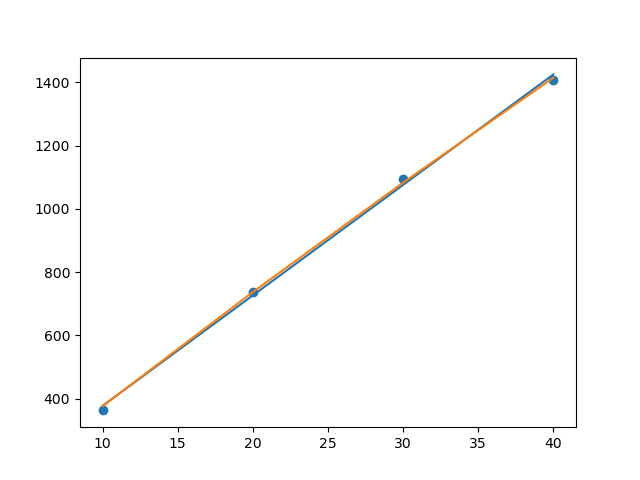

In [17]:
plt.figure()
plt.scatter(ampset[:4], photons_per_sample)
plt.plot(ampset[:4], linear(ampset[:4],*popt))
plt.plot(ampset[:4], e_output(ampset[:4],*popt1))

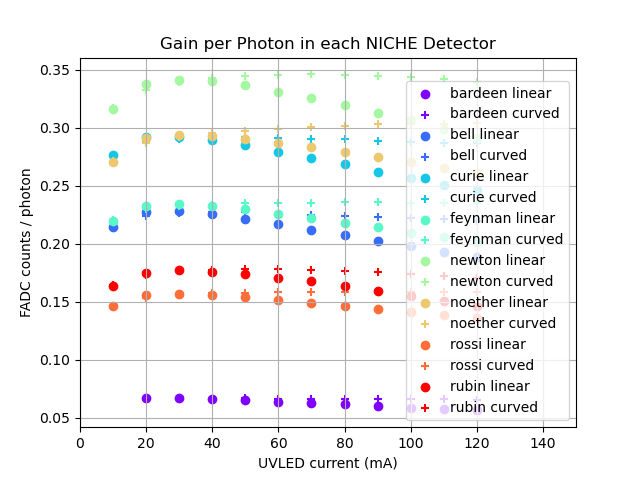

In [18]:
plt.figure()
c = np.arange(len(counters))
colors = plt.cm.rainbow(c/c.max())
for i,counter in enumerate(counters):
    plt.scatter(ampset, meanpulse_dict[counter]/linear(ampset,*popt), color = colors[i], label = f'{counter} linear')
    plt.scatter(ampset, meanpulse_dict[counter]/e_output(ampset,*popt1), color = colors[i], marker='+', label = f'{counter} curved')
plt.xlabel('UVLED current (mA)')
plt.ylabel('FADC counts / photon')
plt.title('Gain per Photon in each NICHE Detector')
plt.xlim(0,150)
plt.grid()
plt.legend(loc=4)

In [13]:
avg_gain = {}
for counter in counters:
    gains = meanpulse_dict[counter]/e_output(ampset,*popt1)
    avg_gain[counter] = np.mean(gains[~np.isnan(gains)])

In [14]:
avg_gain

{'bardeen': 0.06387117319986248,
 'bell': 0.2166096485493284,
 'curie': 0.27957901652151024,
 'feynman': 0.22606300288112502,
 'newton': 0.3296999880500701,
 'noether': 0.2872784885523319,
 'rossi': 0.15169533959943313,
 'rubin': 0.1691053125230736}